In [1]:
from collections import OrderedDict
import os
import torch
import torch.nn as nn
import tiktoken
import numpy as np

from mugato.data.utils import create_combined_dataloader
from mugato.mugato import MugatoConfig, Mugato, TransformerConfig
from mugato.nano_gpt import Block
from mugato.utils import data_home, select_device, generic_collate_fn
from mugato.tokenizer import Tokenizer

In [2]:
n_layer = 6
n_head = 4
n_embd = 512
bias = False
dropout = 0.0
block_size=768
batch_size=4
device = select_device()

In [3]:
text_tokenizer = tiktoken.get_encoding("r50k_base")
tokenizer = Tokenizer(text_tokenizer)

# Ask me about "combined dataloaders".
train_dataloader = iter(create_combined_dataloader(tokenizer, batch_size, split="train", block_size=block_size))
val_dataloader = iter(create_combined_dataloader(tokenizer, batch_size, split="val", block_size=block_size))
test_dataloader = iter(create_combined_dataloader(tokenizer, batch_size, split="test", block_size=block_size))

Let's review how we tokenize text.

In [4]:
original_text = "Hello, abcDEF world!"
original_text

'Hello, abcDEF world!'

In [5]:
encoded = tokenizer.text_tokenizer.encode("Hello, abcDEF world!")
encoded

[15496, 11, 450, 66, 32988, 995, 0]

In [6]:
decoded = tokenizer.text_tokenizer.decode(encoded)
decoded

'Hello, abcDEF world!'

In [7]:
original_text == decoded

True

In [8]:
print(f'{"token":>10}: {"text":>10}')

for token in tokenizer.text_tokenizer.encode("Hello, abcDEF world!"):
    decoded = tokenizer.text_tokenizer.decode([token])
    print(f'{token:>10}: {decoded:>10}')

     token:       text
     15496:      Hello
        11:          ,
       450:         ab
        66:          c
     32988:        DEF
       995:      world
         0:          !


In [9]:
text_tokenizer.decode([text_tokenizer.eot_token])

'<|endoftext|>'

Now let's talk about how we'll tokenize "discrete actions", like pressing "up" or "b" on an Atari controller.

In [10]:
text_tokenizer.n_vocab

50257

In [11]:
tokenizer.n_discrete

1024

If `1` represents "down" on an Atari controller:

In [12]:
tokenizer.encode_discrete(1)

tensor([50258])

We encode discrete variables just beyond the range of our text encoding.

In [13]:
for i in range(5):
    print(tokenizer.encode_discrete(i))

tensor([50257])
tensor([50258])
tensor([50259])
tensor([50260])
tensor([50261])


In [14]:
tokenizer.decode_text(torch.tensor([[50256]]))

'<|endoftext|>'

Now let's create our model. Then we'll look at how we turn those tokens into embeddings.

In [15]:
# model init
transformer_model_args = dict(
    n_layer=n_layer,
    n_head=n_head,
    n_embd=n_embd,
    block_size=block_size,
    bias=bias,
    vocab_size=50257,  # tiktoken.get_encoding("r50k_base").n_vocab
    dropout=dropout,
)  # start with model_args from command line

mugato_model_args = dict(
    n_embd=n_embd,
    block_size=block_size,
    vocab_size=51281,  # text vocab + discrete vocab
)

In [17]:
# create the model
transformer_config = TransformerConfig(**transformer_model_args)
transformer = nn.ModuleDict(
    dict(
        wpe=nn.Embedding(transformer_config.block_size, transformer_config.n_embd),
        drop=nn.Dropout(transformer_config.dropout),
        h=nn.ModuleList(
            [
                Block(transformer_config)
                for _ in range(transformer_config.n_layer)
            ]
        ),
    )
)
mugato_config = MugatoConfig(**mugato_model_args)
untrained_model = Mugato(tokenizer, transformer, mugato_config)

In [18]:
untrained_model = untrained_model.to(device);

In [19]:
print(str(untrained_model)[:300] + "...")

Mugato(
  (lookup_embedding): Embedding(51281, 512)
  (image_embedding): ResNetV2(
    (stem): Sequential(
      (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    ...


Let's see how our untrained model performs.

In [20]:
untrained_model.eval()
text = "First Citizen:\n"
tokens = torch.stack([torch.concat([torch.tensor([tokenizer.eot_token_id]).unsqueeze(0), tokenizer.encode_text(text)])])

In [21]:
tokens

tensor([[[50256],
         [ 5962],
         [22307],
         [   25],
         [  198]]])

In [37]:
# You can ignore the next few lines. Happy to go into it, but it's technical implementation details.
xs = OrderedDict(text=tokens)
xs, ys, ms = generic_collate_fn([[xs, xs]])

next_word_token = None
i = 0
xs, ys, ms = [x.to(device) for x in [xs, ys, ms]]

# This is where we send our tokens through our model and get back "logits".
# Logits are like the "score" of how good each word is (how well it fits given the previous text).
with torch.no_grad():
    logits, loss = untrained_model(xs, pad=False)

# Temperature controls how "flat" is the probability distribution over the possible next words.
temp = 0.6
scaled_logits = logits / temp
probs = scaled_logits.softmax(dim=2)

# Select the word based on the probabilities above
next_word_token = torch.multinomial(probs[0, [-1]], num_samples=1)
next_word = tokenizer.decode_text(next_word_token)
text += next_word
tokens = torch.stack([tokenizer.encode_text(text)])
print(text)

First Citizen:
uggets steer listensßXY Wytypes disruption NoticecodedThose LightingocketsCong estate


It's completely random nonsense, as expected. At least it doesn't throw exceptions! (A pleasant surprise!)

Let's grab a single sample so and try to train on it.

In [47]:
# TODO:

Let's check out how it works with a robotic dataset that combines text, image, and actions.

In [48]:
from mugato.data.four_rooms import (
    initialize as initialize_four_rooms, 
    create_dataloader as create_four_rooms_dataloader, 
    tokenize as four_rooms_tokenize
)


In [49]:
four_rooms_dataset = initialize_four_rooms()
four_rooms_dataloader = create_four_rooms_dataloader(tokenizer, batch_size=batch_size, split="test")
batch = next(iter(four_rooms_dataloader))
X, Y, M = batch
X, Y, M = X.to(device), Y.to(device), M.to(device)
logits, loss = untrained_model(X, Y, M)

# Before we print the "loss" here, what do you expect it to be?

# The "loss" is how far away we are from our prediction.

# How many classes do we have? How many possible output tokens?

In [50]:
total_num_tokens = tokenizer.n_text + tokenizer.n_discrete
total_num_tokens

51281

In [51]:
import math

In [52]:
-math.log(1/51281)

10.845075592184445

In [53]:
loss

tensor(11.0579, device='cuda:0', grad_fn=<DivBackward0>)

In [54]:
# With a completely random model, what do we expect the probability of any given token to be, on average?

# Test Four Rooms

In [55]:
test_data = four_rooms_dataset["test"]

In [56]:
episode = test_data[1]

In [57]:
# TODO: Render mode that works in Jupyter notebook.
env = test_data.recover_environment(render_mode="human")
obs, info = env.reset()
obs['direction'] = np.array([obs['direction']])
obs['image'] = np.array([obs['image']])
obs['mission'] = [obs['mission']]
dummy_action = 0  # Will be sliced off after sequencing.
obs['action'] = np.array([dummy_action])

glx: failed to create dri3 screen
failed to load driver: nouveau
glx: failed to create dri3 screen
failed to load driver: nouveau


In [58]:
env

<OrderEnforcing<PassiveEnvCheckerWGWGWGWGWGWGWGWGWGWGWGWGWGWGWGWGWGWGWG
WG                WG                WG
WG                WG                WG
WG                WG                WG
WG                WG                WG
WG                WG                WG
WG                WG                WG
WG                                  WG
WG  <<            WG                WG
WGWGWGWG  WGWGWGWGWGWGWGWGWG  WGWGWGWG
WG                WG                WG
WG                WG                WG
WG                WG                WG
WG                WG                WG
WG                WG              GGWG
WG                                  WG
WG                WG                WG
WG                WG                WG
WGWGWGWGWGWGWGWGWGWGWGWGWGWGWGWGWGWGWG>>

In [59]:
obs

{'image': array([[[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [2, 5, 0],
          [1, 0, 0],
          [1, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [2, 5, 0],
          [1, 0, 0],
          [1, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [2, 5, 0],
          [1, 0, 0],
          [1, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
       

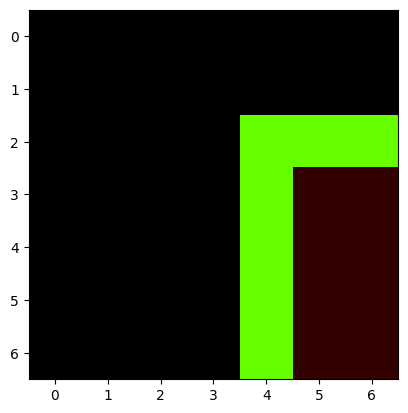

In [60]:
import matplotlib.pyplot as plt
plt.imshow(obs['image'][0].astype(np.float32) / 5)

In [62]:
from mugato.data.four_rooms import four_rooms_to_rgb
from mugato.utils import image_transform
from mugato.utils import Timesteps

In [63]:
tokenizer.separator

1023

In [64]:
def tokenize(obs):
    # Separately encode the mission text, the discrete direction, and the image observation.
    
    mission_tokens = [
        tokenizer.encode_text(mission)
        for mission in obs["mission"]
    ]
    direction_tokens = [
        tokenizer.encode_discrete([direction])
        for direction in obs["direction"]
    ]
    _image = obs["image"]
    _image = four_rooms_to_rgb(_image)
    image_tokens = [tokenizer.encode_image(image) for image in image_transform(_image)]
    action_tokens = [
        tokenizer.encode_discrete([tokenizer.separator, action])
        for action in obs["action"]
    ]

    mission = torch.stack(mission_tokens)
    direction = torch.stack(direction_tokens)
    image = torch.stack(image_tokens)
    action = torch.stack(action_tokens)
    xs = Timesteps({
        "mission": mission,
        "direction": direction,
        "image": image,
        "action": action,
    })
    return xs

In [65]:
xs = tokenize(obs)
# Notice that the image isn't really a "token" in the same sense as text/discrete are.
xs

Timesteps([('mission',
            tensor([[[16250],
                     [  262],
                     [ 3061]]])),
           ('direction', tensor([[[50259]]])),
           ('image',
            tensor([[[ 0.2500,  0.2500,  0.2500,  ..., -0.2230, -0.2230, -0.2230],
                     [ 0.2500,  0.2500,  0.2500,  ..., -0.2230, -0.2230, -0.2230],
                     [ 0.2500,  0.2500,  0.2500,  ..., -0.2230, -0.2230, -0.2230],
                     ...,
                     [ 0.1782,  0.1895,  0.2008,  ..., -0.2230, -0.2230, -0.2230],
                     [ 0.2500,  0.2500,  0.2500,  ..., -0.2230, -0.2230, -0.2230],
                     [ 0.2500,  0.2500,  0.2500,  ..., -0.2230, -0.2230, -0.2230]]])),
           ('action',
            tensor([[[51280],
                     [50257]]]))])

In [66]:
# Add batch dimension.
xs = Timesteps([
    (k, torch.stack([v])) for k, v in xs.items()
])

In [67]:
def sequence_four_rooms(embedder, xs, ys=None, ms=None, sequence_length=1024, pad=True):
    # Refer to the Gato paper for the sequencing diagram.
    
    embeddings = torch.concat([embedder.embed(v) for k, v in xs.items()], dim=2)
    B, E, T, C = embeddings.shape
    embeddings = embeddings.view(B, E * T, C)
    # Slice off final actions, so we can predict it.
    return embeddings[:, :-1]

In [68]:
next_word_token = None
i = 0
xs = xs.to(device)
logits, loss = untrained_model(xs, pad=False, sequence=sequence_four_rooms)
temp = 0.6
scaled_logits = logits / temp
probs = scaled_logits.softmax(dim=2)
next_token = torch.multinomial(probs[0, [-1]], num_samples=1)
next_token = tokenizer.decode_discrete(next_token)

In [69]:
# This is the "action" token that we're predicting.
# It's just as gibberish as the text we were generating before.
next_token

[14686]

In [70]:
def get_action(token, action_space):
    # This is just how we turn any arbitrary wrong action token into a valid (but wrong) Gym environment action.
    # Our code would blow up if we told our Gym environment to take action 16266. That's out of
    # the range of valid actions.
    return token % tokenizer.n_text % env.action_space.n

In [71]:
get_action(next_token[0], env.action_space.n)

np.int64(0)

In [144]:
# Track memory usage
import gc
import torch.cuda

def print_gpu_memory():
    print(f"Allocated: {torch.cuda.memory_allocated()/1e9:.2f}GB")
    print(f"Cached: {torch.cuda.memory_reserved()/1e9:.2f}GB")

print("Initial GPU memory:")
print_gpu_memory()


Initial GPU memory:
Allocated: 10.67GB
Cached: 11.58GB


In [145]:
for _ in range(10):
    # Clear memory before each iteration
    torch.cuda.empty_cache()
    gc.collect()
    
    # Step with the previously predicted action: `next_token[0]`
    obs, reward, terminated, truncated, info = env.step(get_action(next_token[0], env))
    
    # Prepare the next observation.
    obs['direction'] = np.array([obs['direction']])
    obs['image'] = np.array([obs['image']])
    obs['mission'] = [obs['mission']]
    # Prepare a temporary action token. Will be sliced off after sequencing.
    # We just need this because each modality of the episodes need to have 
    # the same `E` dimension (remember - (B, E, T, C)), so that we can 
    # concatenate them on the `T` dimension.
    dummy_action = 0
    obs['action'] = np.array([dummy_action])
    
    # Move old tensors to CPU to free GPU memory
    xs = xs.to("cpu")
    
    xs_new = tokenize(obs)
    # Merge the new episode.
    xs = Timesteps([
        (k, torch.concat([xs[k], xs_new[k].to("cpu").unsqueeze(0)])) for k in xs.keys()
    ])
    
    # Only move to GPU right before model inference
    xs = xs.to(device)
    
    # Predict the next action
    with torch.no_grad():  # Use mixed precision to reduce memory
        logits, loss = untrained_model(xs, pad=False, sequence=sequence_four_rooms)
    
    temp = 0.8
    scaled_logits = logits / temp
    probs = scaled_logits.softmax(dim=2)
    next_token = torch.multinomial(probs[0, [-1]], num_samples=1)
    next_token = tokenizer.decode_discrete(next_token)
    
    # Move tensors back to CPU and clear GPU cache
    xs = xs.to("cpu")
    logits = logits.to("cpu")
    probs = probs.to("cpu")
    torch.cuda.empty_cache()
    
    print(f"Next token: {next_token}")

Next token: [46182]
Next token: [9841]
Next token: [8374]
Next token: [30912]
Next token: [5240]
Next token: [20185]
Next token: [27804]
Next token: [3663]
Next token: [32419]
Next token: [34277]


In [146]:
env.close()

In [147]:
torch.cuda.empty_cache()
gc.collect()

0

# Trained model

In [150]:
out_dir = data_home / "out"
ckpt_path = os.path.join(out_dir, "ckpt.pt")
checkpoint = torch.load(ckpt_path, map_location=device, weights_only=True)

state_dict = checkpoint["model"]
# fix the keys of the state dictionary :(
# honestly no idea how checkpoints sometimes get this prefix, have to debug more
unwanted_prefix = "_orig_mod."
for k, v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix) :]] = state_dict.pop(k)
checkpoint_model_args = checkpoint["model_args"]
for k in ["n_layer", "n_head", "n_embd", "block_size", "bias", "vocab_size"]:
    transformer_model_args[k] = checkpoint_model_args[k]

transformer_config = TransformerConfig(**transformer_model_args)
transformer = nn.ModuleDict(
    dict(
        wpe=nn.Embedding(transformer_config.block_size, transformer_config.n_embd),
        drop=nn.Dropout(transformer_config.dropout),
        h=nn.ModuleList(
            [
                Block(transformer_config)
                for _ in range(transformer_config.n_layer)
            ]
        ),
    )
)

mugato_config = MugatoConfig(**mugato_model_args)
trained_model = Mugato(tokenizer, transformer, mugato_config)
trained_model.load_state_dict(state_dict)
iter_num = checkpoint["iter_num"]
best_val_loss = checkpoint["best_val_loss"]

trained_model = trained_model.to(device);

In [151]:
trained_model.eval()
text = "First Citizen:\n"
tokens = torch.stack([torch.concat([torch.tensor([tokenizer.eot_token_id]).unsqueeze(0), tokenizer.encode_text(text)])])

In [178]:
xs = OrderedDict(text=tokens)
xs, ys, ms = generic_collate_fn([[xs, xs]])
next_word_token = None
i = 0
xs, ys, ms = [x.to(device) for x in [xs, ys, ms]]
logits, loss = trained_model(xs, pad=False)
temp = 0.6
scaled_logits = logits / temp
probs = scaled_logits.softmax(dim=2)
next_word_token = torch.multinomial(probs[0, [-1]], num_samples=1)
next_word = tokenizer.decode_text(next_word_token)
text += next_word
tokens = torch.stack([tokenizer.encode_text(text)])
print(text)

First Citizen:
Right, good word.

!

 word, good old!

 word,
Not to the poor souls,



In [179]:
env = test_data.recover_environment(render_mode="human")
obs, info = env.reset()
obs['direction'] = np.array([obs['direction']])
obs['image'] = np.array([obs['image']])
obs['mission'] = [obs['mission']]
dummy_action = 0  # Will be sliced off after sequencing.
obs['action'] = np.array([dummy_action])
xs = tokenize(obs)
# Add batch dimension.
xs = Timesteps([
    (k, torch.stack([v])) for k, v in xs.items()
])

In [180]:
next_word_token = None
i = 0
xs = xs.to(device)
logits, loss = trained_model(xs, pad=False, sequence=sequence_four_rooms)
temp = 0.6
scaled_logits = logits / temp
probs = scaled_logits.softmax(dim=2)
next_token = torch.multinomial(probs[0, [-1]], num_samples=1)
next_token = tokenizer.decode_discrete(next_token)

In [181]:
for _ in range(10):
    # Clear memory before each iteration
    torch.cuda.empty_cache()
    gc.collect()
    
    # Step with the previously predicted action: `next_token[0]`
    obs, reward, terminated, truncated, info = env.step(get_action(next_token[0], env))
    
    # Prepare the next observation.
    obs['direction'] = np.array([obs['direction']])
    obs['image'] = np.array([obs['image']])
    obs['mission'] = [obs['mission']]
    # Prepare a temporary action token. Will be sliced off after sequencing.
    # We just need this because each modality of the episodes need to have 
    # the same `E` dimension (remember - (B, E, T, C)), so that we can 
    # concatenate them on the `T` dimension.
    dummy_action = 0
    obs['action'] = np.array([dummy_action])
    
    # Move old tensors to CPU to free GPU memory
    xs = xs.to("cpu")
    
    xs_new = tokenize(obs)
    # Merge the new episode.
    xs = Timesteps([
        (k, torch.concat([xs[k], xs_new[k].to("cpu").unsqueeze(0)])) for k in xs.keys()
    ])
    
    # Only move to GPU right before model inference
    xs = xs.to(device)
    
    # Predict the next action
    with torch.no_grad():  # Use mixed precision to reduce memory
        logits, loss = trained_model(xs, pad=False, sequence=sequence_four_rooms)
    
    temp = 0.8
    scaled_logits = logits / temp
    probs = scaled_logits.softmax(dim=2)
    next_token = torch.multinomial(probs[0, [-1]], num_samples=1)
    next_token = tokenizer.decode_discrete(next_token)
    
    # Move tensors back to CPU and clear GPU cache
    xs = xs.to("cpu")
    logits = logits.to("cpu")
    probs = probs.to("cpu")
    torch.cuda.empty_cache()
    
    print(f"Next token: {next_token}")

Next token: [2]
Next token: [2]
Next token: [2]
Next token: [2]
Next token: [2]
Next token: [2]
Next token: [1]
Next token: [1]
Next token: [0]
Next token: [2]


In [44]:
env.close()